# Preparing the dataset, training, and testing

## imports

In [3]:
import pandas as pd
import shutil
import random
from DicomRTTool.ReaderWriter import DicomReaderWriter, ROIAssociationClass
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset, TensorDataset
import pickle
import json
import torch.nn.functional as F
import tqdm
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
import seaborn as sns
from sklearn.preprocessing import label_binarize


## Prep training dataset

### Define the dataset class

In [37]:
class CTDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data[index]
        label = self.labels[index]
        return image, label

### Load the dataset lists
1. array list that is a list of numpy arrays for each slice
2. corresponding label list

In [17]:
np_folder_path = '/home/lam3654/MSAI_pneumonitis/data/pneumonitis_np'

In [30]:
loaded_array_list = np.load(os.path.join(np_folder_path, "train_arrays.npy"), allow_pickle=True)

with open(os.path.join(np_folder_path, "train_labels_np.json"), "r") as file:
    train_labels_list = json.load(file)

### Build and load the dataset

In [38]:
dataset = CTDataset(loaded_array_list, train_labels_list)
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)

## Define model structure

In [59]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 128 * 128, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 128 * 128)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Train model

In [70]:
# Check if a GPU is available and if not, default to CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}")

# Initialize the model, loss function, and optimizer
model = CNNClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

output_list = []
num_epochs = 10 
for epoch in range(num_epochs):
    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        images = images[:, np.newaxis, :, :]
        images = images.float()

        # Forward pass
        outputs = model(images)
        output_list.append(outputs)
        loss = criterion(outputs, labels)
        _, predicted = outputs.max(1)
        # Backward and optimize
        loss.backward()
        optimizer.step()
    # Print the loss after each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")




Training on cuda:0
Batch 1 predictions: [1, 1, 0, 1]
Batch 2 predictions: [0, 0, 0, 0]
Batch 3 predictions: [0, 0, 0, 0]
Batch 4 predictions: [0, 0, 0, 0]
Batch 5 predictions: [1, 0, 1, 0]
Batch 6 predictions: [1, 0, 1, 1]
Batch 7 predictions: [0, 1, 0, 1]
Batch 8 predictions: [1, 0, 1, 1]
Batch 9 predictions: [0, 1, 1, 1]
Batch 10 predictions: [0, 1, 1, 0]
Batch 11 predictions: [1, 0, 0, 1]
Batch 12 predictions: [0, 0, 1, 0]
Batch 13 predictions: [0, 0, 0, 0]
Batch 14 predictions: [0, 0, 1, 1]
Batch 15 predictions: [0, 0, 0, 0]
Batch 16 predictions: [0, 0, 0, 0]
Batch 17 predictions: [0, 0, 0, 0]
Batch 18 predictions: [0, 0, 0, 0]
Batch 19 predictions: [0, 0, 0, 0]
Batch 20 predictions: [0, 0, 0, 0]
Batch 21 predictions: [0, 0, 0, 0]
Batch 22 predictions: [0, 0, 0, 0]
Batch 23 predictions: [0, 0, 0, 0]
Batch 24 predictions: [0, 0, 0, 0]
Batch 25 predictions: [0, 0, 0, 0]
Batch 26 predictions: [0, 0, 1, 0]
Batch 27 predictions: [0, 0, 0, 0]
Batch 28 predictions: [0, 0, 0, 0]
Batch 29 p

## Save trained model

In [ ]:
model_path = '/home/lam3654/MSAI_pneumonitis/lung_cancer_radiomics/first_model.pt'
torch.save(model.state_dict(), model_path)

## Dev set

### Open trained model

In [96]:
model_path = '/home/lam3654/MSAI_pneumonitis/lung_cancer_radiomics/first_model.pt'

model = CNNClassifier()  # Replace YourModelClass with the actual class of your model
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

### Open dev list files

In [87]:
with open(os.path.join(path, "dev_data.json"), "r") as file:
    dev_data = json.load(file)

with open(os.path.join(path, "dev_labels.json"), "r") as file:
    dev_labels = json.load(file)

### Get numpy arrays

In [88]:
total_dev_arrays = []
total_dev_labels = []

for i in range(len(dev_data)):
    try:
        single_arrays = []
        Dicom_path = dev_data[i]
        Dicom_reader = DicomReaderWriter(description='Examples', arg_max=True)
        Dicom_reader.walk_through_folders(Dicom_path) 
        # all_rois = Dicom_reader.return_rois(print_rois=True) # Return a list of all rois present

        Contour_names = ['lung'] 
        associations = [ROIAssociationClass('lung', lung_list)]
        Dicom_reader.set_contour_names_and_associations(contour_names=Contour_names, associations=associations)
        indexes = Dicom_reader.which_indexes_have_all_rois()
        if indexes != []:
            pt_indx = indexes[-1]
            Dicom_reader.set_index(pt_indx) 
            Dicom_reader.get_images_and_mask()  

            image = Dicom_reader.ArrayDicom # image array
            mask = Dicom_reader.mask # mask array

            slice_locations = np.unique(np.where(mask != 0)[0]) # get indexes for where there is a contour present 
            slice_start = slice_locations[0] # first slice of contour 
            slice_end = slice_locations[len(slice_locations)-1] # last slice of contour

            counter = 1

            for img_arr, contour_arr in zip(image[slice_start:slice_end+1], mask[slice_start:slice_end+1]): 
                if counter % skip == 0: # if current slice is divisible by desired skip amount 
                    select = np.multiply(img_arr, contour_arr)
                    single_arrays.append(select)
                counter += 1
        single_labels = [dev_labels[i] for x in range(len(single_arrays))]
        total_dev_arrays = total_dev_arrays + single_arrays
        total_dev_labels = total_dev_labels + single_labels
    except TypeError:
        print("skip this dataset")
        continue

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0450


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.33s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0450
Index 1, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0450
Index 2, description CHEST 3MM  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0450
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0450
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0450
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0450
Index 6, description None at None
7 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0450. Found []
Lacking ['lung'] in index 2, location /home/lam3654/M

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0830


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.36s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0830
Index 1, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0830
Index 2, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0830
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0830. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0830. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0830
Finished listing present 

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1181


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.58s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1181
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1181
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1181
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1181
Index 4, description THORAX  1.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1181
Index 5, description None at None
6 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1181. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1181. Found []
Lacking ['lung'] in index 3, location /home/lam3654/

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1277


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.05s/it]


Compiling dictionaries together...
Index 0, description AIP 0,10,20,30,40,50,60,70,80,90%  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1277
Index 1, description Chest   3.0  B35s  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1277
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1277. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1277
Finished listing present indexes
Loading images for AIP 0,10,20,30,40,50,60,70,80,90%  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1277

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0506


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.53s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0506
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0506
Finished listing present indexes
Loading images for NEW 4DCT/OncoBody  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0506

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1080


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.50s/it]


Compiling dictionaries together...
Index 0, description AVG 10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1080
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1080
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1080. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1080
Finished listing present indexes
Loading images for AVG 10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1080

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0138


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.97s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0138
Index 1, description SOFT TISSUE ID1  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0138
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0138
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0138
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0138
Index 5, description None at None
6 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0138. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0138. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MS

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0241


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:26<00:00, 26.64s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0241
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0241
Index 2, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0241
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0241
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0241
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0241
Index 6, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0241
Index 7, description None at None
8 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pne

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0123


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.80s/it]


Compiling dictionaries together...
Index 0, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0123
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0123
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0123
Index 3, description CHEST WITHOUT  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0123
Index 4, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0123
Index 5, description None at None
6 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0123. Found []
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0123. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/dat

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1122


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1122
Index 1, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1122
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1122. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1122
Finished listing present indexes
Loading images for NEW 4DCT/OncoBody  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1122

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1308


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.01s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1308
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1308
Finished listing present indexes
Loading images for AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1308

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1084


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:25<00:00, 25.21s/it]


Compiling dictionaries together...
Index 0, description Mean IP: Derived CT 20150724 144420  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1084
Index 1, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1084
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1084
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1084
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1084
Index 5, description Axial mediastinum THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1084
Index 6, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1084
Index 7, description None at None
8 unique series IDs were found. Default is index 0, to change use set_index(index)
Lackin

Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0154/2012-11__Studies/NU.0154_NU.0154_RTst_2012-11-15_085307_sbrt.lung.plan.scan_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0154/2012-11__Studies/NU.0154_NU.0154_RTDOSE_2012-11-15_085307_sbrt.lung.plan.scan_NU.0154_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0154/2012-11__Studies/NU.0154_NU.0154_CT_2012-11-15_085307_sbrt.lung.plan.scan_NU.0154_n174__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0154/2012-11__Studies/NU.0154_NU.0154_RTPLAN_2012-11-15_085307_sbrt.lung.plan.scan_NU.0154_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0154/2012-11__Studies/NU.0154_NU.0154_RTPLAN_2012-11-15_085307_sbrt.lung.plan.scan_NU.0154_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569059742.217.882.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.45it/s]


Compiling dictionaries together...
Index 0, description NU_0154  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0154/2012-11__Studies/NU.0154_NU.0154_CT_2012-11-15_085307_sbrt.lung.plan.scan_NU.0154_n174__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0154/2012-11__Studies/NU.0154_NU.0154_CT_2012-11-15_085307_sbrt.lung.plan.scan_NU.0154_n174__00000
Finished listing present indexes
Loading images for NU_0154  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0154/2012-11__Studies/NU.0154_NU.0154_CT_2012-11-15_085307_sbrt.lung.plan.scan_NU.0154_n174__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0889


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.79s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0889
Index 1, description Axial Mediastinum Chest 3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0889
Index 2, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0889
Index 3, description CHEST W/O  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0889
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0889. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0889. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0889. 

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1253


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.10s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1253
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1253
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1253

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0029


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:28<00:00, 28.74s/it]


Compiling dictionaries together...
Index 0, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0029
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0029
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0029
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0029
Index 4, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0029
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0029
Index 6, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0029
Index 7, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0029
Index 8, description 4D CT/OncoBody at /home/lam3654/MSAI_p

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0567


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.37s/it]


Compiling dictionaries together...
Index 0, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0567
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0567
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0567
Index 3, description CHEST 3MM  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0567
Index 4, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0567
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0567
Index 6, description Chest 3mm  3.0  B30f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0567
Index 7, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0567
Index 8, description None at None
9 unique series IDs were fo

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1123


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.84s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1123
Index 1, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1123
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1123
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1123
Index 4, description Thorax  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1123
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1123
Index 6, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1123
Index 7, description Chest  3.0  x 1.5 B30f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1123
Index 8, description Thorax  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/dat

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0155


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:20<00:00, 20.38s/it]


Compiling dictionaries together...
Index 0, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0155
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0155
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0155
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0155
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0155
Index 5, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0155
Index 6, description None at None
7 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0155. Found []
Lacking ['lung'] in index 1, location /home/lam3654/M

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1292


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.53s/it]


Compiling dictionaries together...
Index 0, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1292
Index 1, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1292
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1292. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 1, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1292
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1292

Erasing any previous mask as we load a new new image set


Loading through DICOM files:  50%|███████████████████████████████████                                   | 2/4 [00:00<00:00, 19.84it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0072/2013-06__Studies/NU.0072_NU.0072_RTDOSE_2013-06-08_091351_RUL.SBRT.planning_NU.0072_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0072/2013-06__Studies/NU.0072_NU.0072_RTPLAN_2013-06-08_091351_RUL.SBRT.planning_NU.0072_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0072/2013-06__Studies/NU.0072_NU.0072_CT_2013-06-08_091351_RUL.SBRT.planning_NU.0072_n184__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0072/2013-06__Studies/NU.0072_NU.0072_RTst_2013-06-08_091351_RUL.SBRT.planning_AY_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0072/2013-06__Studies/NU.0072_NU.0072_RTPLAN_2013-06-08_091351_RUL.SBRT.planning_NU.0072_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569053534.550.8050.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.49it/s]


Compiling dictionaries together...
Index 0, description NU_0072  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0072/2013-06__Studies/NU.0072_NU.0072_CT_2013-06-08_091351_RUL.SBRT.planning_NU.0072_n184__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0072/2013-06__Studies/NU.0072_NU.0072_CT_2013-06-08_091351_RUL.SBRT.planning_NU.0072_n184__00000. Found ['lung_l1', 'lung_r1', 'itv rul nodule', 'ptv rul nodule', 'gtv_research_tpct', 'r lung - gtv', 'r lung - itv', 'gtv + 2 cm', 'tl-gtv']
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Finished listing present indexes


Loading through DICOM files:  50%|███████████████████████████████████                                   | 2/4 [00:00<00:00, 19.44it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0190/2011-12__Studies/NU.0190_NU.0190_RTPLAN_2011-12-12_110757_SBRT.Lung.planning..bellows_NU.0190_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0190/2011-12__Studies/NU.0190_NU.0190_RTDOSE_2011-12-12_110757_SBRT.Lung.planning..bellows_NU.0190_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0190/2011-12__Studies/NU.0190_NU.0190_CT_2011-12-12_110757_SBRT.Lung.planning..bellows_NU.0190_n196__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0190/2011-12__Studies/NU.0190_NU.0190_RTst_2011-12-12_110757_SBRT.Lung.planning..bellows_AY_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0190/2011-12__Studies/NU.0190_NU.0190_RTPLAN_2011-12-12_110757_SBRT.Lung.planning..bellows_NU.0190_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569049358.706.4636.d

Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.32it/s]


Compiling dictionaries together...
Index 0, description NU_0190  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0190/2011-12__Studies/NU.0190_NU.0190_CT_2011-12-12_110757_SBRT.Lung.planning..bellows_NU.0190_n196__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0190/2011-12__Studies/NU.0190_NU.0190_CT_2011-12-12_110757_SBRT.Lung.planning..bellows_NU.0190_n196__00000
Finished listing present indexes
Loading images for NU_0190  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0190/2011-12__Studies/NU.0190_NU.0190_CT_2011-12-12_110757_SBRT.Lung.planning..bellows_NU.0190_n196__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0535


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.91s/it]


Compiling dictionaries together...
Index 0, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0535
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0535
Index 2, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0535
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0535. Found []
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0535. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 2, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0535
Finished listing present indexes
Loading images for NEW 4DCT/OncoBody  at 
 /home/lam36

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0621


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.97s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0621
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0621
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0621
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0621
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0621. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0621. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0621. Found []
Contour names or associations changed, resettin

Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0149/2010-12__Studies/NU.0149_NU.0149_CT_2010-12-06_111436_SBRT.lung.planning_NU.0149_n216__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0149/2010-12__Studies/NU.0149_NU.0149_RTst_2010-12-06_111436_SBRT.lung.planning_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0149/2010-12__Studies/NU.0149_NU.0149_RTPLAN_2010-12-06_111436_._NU.0149_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0149/2010-12__Studies/NU.0149_NU.0149_RTDOSE_2010-12-06_111436_._NU.0149_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0149/2010-12__Studies/NU.0149_NU.0149_RTPLAN_2010-12-06_111436_._NU.0149_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569049791.993.2099.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.21it/s]


Compiling dictionaries together...
Index 0, description NU_0149  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0149/2010-12__Studies/NU.0149_NU.0149_CT_2010-12-06_111436_SBRT.lung.planning_NU.0149_n216__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0149/2010-12__Studies/NU.0149_NU.0149_CT_2010-12-06_111436_SBRT.lung.planning_NU.0149_n216__00000
Finished listing present indexes
Loading images for NU_0149  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0149/2010-12__Studies/NU.0149_NU.0149_CT_2010-12-06_111436_SBRT.lung.planning_NU.0149_n216__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1224


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.48s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1224
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1224
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1224
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1224
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1224
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1224
Index 6, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1224
Index 7, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1199


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.86s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1199
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1199
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1199. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1199
Finished listing present indexes
Loading images for 4D CT/OncoBody at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1199

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0640


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.04s/it]


Compiling dictionaries together...
Index 0, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0640
Index 1, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0640
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0640. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 1, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0640
Finished listing present indexes
Loading images for 4D CT/OncoBody at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0640

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0657


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.73s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0657
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0657
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0657
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0657. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0657. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0657
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneum

### Save numpy data lists

In [89]:
np_folder_path = '/home/lam3654/MSAI_pneumonitis/data/pneumonitis_np'

In [90]:
np.save(os.path.join(np_folder_path, "dev_arrays.npy"), total_dev_arrays)


with open(os.path.join(np_folder_path, "dev_labels_np.json"), "w") as file:
    json.dump(total_dev_labels, file)

### Build dev dataset

In [91]:
dev_array_list = np.load(os.path.join(np_folder_path, "dev_arrays.npy"), allow_pickle=True)

with open(os.path.join(np_folder_path, "dev_labels_np.json"), "r") as file:
    dev_labels_list = json.load(file)

In [92]:
print(len(dev_array_list))

515


In [93]:
dev_dataset = CTDataset(dev_array_list, dev_labels_list)
dev_data_loader = DataLoader(dev_dataset, batch_size=4, shuffle=True)

### Run testing

In [97]:
model.eval()  # Set the model to evaluation mode

true_labels = []
pred_labels = []
outputs_list = []

# Loop through the test data
for inputs, labels in dev_data_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    inputs = inputs[:, np.newaxis, :, :]
    inputs = inputs.float()


    # Forward pass
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)  # Get the predicted classes

    true_labels.extend(labels.cpu().numpy())
    pred_labels.extend(preds.cpu().numpy())
    outputs_list.extend(outputs.detach().cpu().numpy())

# Convert to numpy arrays for use with sklearn
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# Compute ROC AUC
roc_auc = roc_auc_score(label_binarize(true_labels, classes=[0,1]),
                        label_binarize(pred_labels, classes=[0,1]), 
                        average='macro')

# Compute accuracy
accuracy = accuracy_score(true_labels, pred_labels)

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

### Run training 

In [95]:
# Check if a GPU is available and if not, default to CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}")

# Initialize the model, loss function, and optimizer
model = CNNClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

output_list = []
num_epochs = 10 
for epoch in range(num_epochs):
    image_count = 0
    for images, labels in dev_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        images = images[:, np.newaxis, :, :]
        images = images.float()

        # Forward pass
        outputs = model(images)
        output_list.append(outputs)
        loss = criterion(outputs, labels)
        _, predicted = outputs.max(1)
        image_count += 1
        # Backward and optimize
        loss.backward()
        optimizer.step()
    print('number of images: ', image_count)
    # Print the loss after each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


# Save the model
model_save_path = "./model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Training on cuda:0


KeyboardInterrupt: 

## Test model

### Open test list files

In [73]:
with open(os.path.join(path, "test_data.json"), "r") as file:
    test_data = json.load(file)

with open(os.path.join(path, "test_labels.json"), "r") as file:
    test_labels = json.load(file)

### Get Numpy arrays

In [74]:
total_test_arrays = []
total_test_labels = []

for i in range(len(test_data)):
    try:
        single_arrays = []
        Dicom_path = test_data[i]
        Dicom_reader = DicomReaderWriter(description='Examples', arg_max=True)
        Dicom_reader.walk_through_folders(Dicom_path) 
        # all_rois = Dicom_reader.return_rois(print_rois=True) # Return a list of all rois present

        Contour_names = ['lung'] 
        associations = [ROIAssociationClass('lung', lung_list)]
        Dicom_reader.set_contour_names_and_associations(contour_names=Contour_names, associations=associations)
        indexes = Dicom_reader.which_indexes_have_all_rois()
        if indexes != []:
            pt_indx = indexes[-1]
            Dicom_reader.set_index(pt_indx) 
            Dicom_reader.get_images_and_mask()  

            image = Dicom_reader.ArrayDicom # image array
            mask = Dicom_reader.mask # mask array

            slice_locations = np.unique(np.where(mask != 0)[0]) # get indexes for where there is a contour present 
            slice_start = slice_locations[0] # first slice of contour 
            slice_end = slice_locations[len(slice_locations)-1] # last slice of contour

            counter = 1

            for img_arr, contour_arr in zip(image[slice_start:slice_end+1], mask[slice_start:slice_end+1]): 
                if counter % skip == 0: # if current slice is divisible by desired skip amount 
                    select = np.multiply(img_arr, contour_arr)
                    single_arrays.append(select)
                counter += 1
        single_labels = [test_labels[i] for x in range(len(single_arrays))]
        total_test_arrays = total_test_arrays + single_arrays
        total_test_labels = total_test_labels + single_labels
    except TypeError:
        print("skip this dataset")
        continue

Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0134/2017-08__Studies/NU.0134_NU.0134_RTPLAN_2017-08-19_144247_SBRT.LUL.Plan.and.Bellows_NU.0134_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0134/2017-08__Studies/NU.0134_NU.0134_CT_2017-08-19_144247_SBRT.LUL.Plan.and.Bellows_NU.0134_n170__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0134/2017-08__Studies/NU.0134_NU.0134_RTst_2017-08-19_144247_SBRT.LUL.Plan.and.Bellows_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0134/2017-08__Studies/NU.0134_NU.0134_RTDOSE_2017-08-19_144247_SBRT.LUL.Plan.and.Bellows_NU.0134_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0134/2017-08__Studies/NU.0134_NU.0134_RTPLAN_2017-08-19_144247_SBRT.LUL.Plan.and.Bellows_NU.0134_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569051384.715.5526.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.32it/s]


Compiling dictionaries together...
Index 0, description NU_0134  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0134/2017-08__Studies/NU.0134_NU.0134_CT_2017-08-19_144247_SBRT.LUL.Plan.and.Bellows_NU.0134_n170__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0134/2017-08__Studies/NU.0134_NU.0134_CT_2017-08-19_144247_SBRT.LUL.Plan.and.Bellows_NU.0134_n170__00000
Finished listing present indexes
Loading images for NU_0134  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0134/2017-08__Studies/NU.0134_NU.0134_CT_2017-08-19_144247_SBRT.LUL.Plan.and.Bellows_NU.0134_n170__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0315


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0315
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0315. Found ['trach', 'heart', 'right lung', '4d gtv', 'wall of ptv', 'pen', 'eso', 'ptv (gtv+5mm)', 'pen2', 'outer contour', 'prox bronch', 'b plex', 'cord']
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0077/2016-10__Studies/NU.0077_NU.0077_RTst_2016-10-18_110429_SBRT.Lung_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0077/2016-10__Studies/NU.0077_NU.0077_CT_2016-10-18_110429_SBRT.Lung_NU.0077_n145__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0077/2016-10__Studies/NU.0077_NU.0077_RTPLAN_2016-10-18_110429_SBRT.Lung_NU.0077_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0077/2016-10__Studies/NU.0077_NU.0077_RTDOSE_2016-10-18_110429_SBRT.Lung_NU.0077_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0077/2016-10__Studies/NU.0077_NU.0077_RTPLAN_2016-10-18_110429_SBRT.Lung_NU.0077_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569047963.1085.987.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.33it/s]


Compiling dictionaries together...
Index 0, description NU_0077  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0077/2016-10__Studies/NU.0077_NU.0077_CT_2016-10-18_110429_SBRT.Lung_NU.0077_n145__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0077/2016-10__Studies/NU.0077_NU.0077_CT_2016-10-18_110429_SBRT.Lung_NU.0077_n145__00000
Finished listing present indexes
Loading images for NU_0077  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0077/2016-10__Studies/NU.0077_NU.0077_CT_2016-10-18_110429_SBRT.Lung_NU.0077_n145__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:  50%|███████████████████████████████████                                   | 2/4 [00:00<00:00, 19.57it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0147/2017-12__Studies/NU.0147_NU.0147_RTDOSE_2017-12-09_103636_sbrt.lung.planning.bellows_NU.0147_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0147/2017-12__Studies/NU.0147_NU.0147_RTst_2017-12-09_103636_sbrt.lung.planning.bellows_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0147/2017-12__Studies/NU.0147_NU.0147_RTPLAN_2017-12-09_103636_sbrt.lung.planning.bellows_NU.0147_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0147/2017-12__Studies/NU.0147_NU.0147_CT_2017-12-09_103636_sbrt.lung.planning.bellows_NU.0147_n148__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0147/2017-12__Studies/NU.0147_NU.0147_RTPLAN_2017-12-09_103636_sbrt.lung.planning.bellows_NU.0147_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569056052.731.494.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Compiling dictionaries together...
Index 0, description NU_0147  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0147/2017-12__Studies/NU.0147_NU.0147_CT_2017-12-09_103636_sbrt.lung.planning.bellows_NU.0147_n148__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0147/2017-12__Studies/NU.0147_NU.0147_CT_2017-12-09_103636_sbrt.lung.planning.bellows_NU.0147_n148__00000
Finished listing present indexes
Loading images for NU_0147  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0147/2017-12__Studies/NU.0147_NU.0147_CT_2017-12-09_103636_sbrt.lung.planning.bellows_NU.0147_n148__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0570


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:21<00:00, 21.21s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0570
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0570
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0570
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0570
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0570
Index 5, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0570
Index 6, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0570
Index 7, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0570
Index 8, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0560


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.90s/it]


Compiling dictionaries together...
Index 0, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0560
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0560
Index 2, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0560
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0560. Found []
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0560. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 2, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0560
Finished listing present indexes
Loading images for 4D CT/OncoBody at 
 /home/lam3654/MSAI_

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1073


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:20<00:00, 20.28s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1073
Index 1, description CHEST WITHOUT  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1073
Index 2, description CHEST WITHOUT  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1073
Index 3, description CHEST WITHOUT  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1073
Index 4, description CHEST  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1073
Index 5, description CHEST WITHOUT  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1073
Index 6, description None at None
7 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1073. Found []
Lacking ['lung'] in index 2, location /home/lam3654/M

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1269


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.54s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1269
Index 1, description Chest 3mm  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1269
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1269
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1269
Index 4, description CHEST W/O  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1269
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1269
Index 6, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1269
Index 7, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1269
Ind

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0571


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.58s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0571
Index 1, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0571
Index 2, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0571
Index 3, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0571
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0571
Index 5, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0571
Index 6, description None at None
7 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0571. Found []
Lacking ['lung'] in index 2, location /home/lam36

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1106


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.62s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1106
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1106
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1106
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1106. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1106. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1106
Finished listing present indexes
Loading images for NEW 4DCT/OncoBody  at 
 /home/lam36

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0047


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.81s/it]


Compiling dictionaries together...
Index 0, description AVG CHEST/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0047
Index 1, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0047
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0047. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0047
Finished listing present indexes
Loading images for AVG CHEST/OncoBody at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0047

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0084/2017-06__Studies/NU.0084_NU.0084_RTst_2017-06-21_133754_SBRT.Lung.Planning_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0084/2017-06__Studies/NU.0084_NU.0084_RTDOSE_2017-06-21_133754_SBRT.Lung.Planning_NU.0084_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0084/2017-06__Studies/NU.0084_NU.0084_CT_2017-06-21_133754_SBRT.Lung.Planning_NU.0084_n188__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0084/2017-06__Studies/NU.0084_NU.0084_RTPLAN_2017-06-21_133754_SBRT.Lung.Planning_NU.0084_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0084/2017-06__Studies/NU.0084_NU.0084_RTPLAN_2017-06-21_133754_SBRT.Lung.Planning_NU.0084_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569057273.485.6515.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.47it/s]


Compiling dictionaries together...
Index 0, description NU_0084  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0084/2017-06__Studies/NU.0084_NU.0084_CT_2017-06-21_133754_SBRT.Lung.Planning_NU.0084_n188__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0084/2017-06__Studies/NU.0084_NU.0084_CT_2017-06-21_133754_SBRT.Lung.Planning_NU.0084_n188__00000
Finished listing present indexes
Loading images for NU_0084  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0084/2017-06__Studies/NU.0084_NU.0084_CT_2017-06-21_133754_SBRT.Lung.Planning_NU.0084_n188__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0235/2012-05__Studies/NU.0235_NU.0235_CT_2012-05-20_143510_SBRT.Lung.planning.scan_NU.0235_n184__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0235/2012-05__Studies/NU.0235_NU.0235_RTPLAN_2012-05-20_143510_SBRT.Lung.planning.scan_NU.0235_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0235/2012-05__Studies/NU.0235_NU.0235_RTDOSE_2012-05-20_143510_SBRT.Lung.planning.scan_NU.0235_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0235/2012-05__Studies/NU.0235_NU.0235_RTst_2012-05-20_143510_SBRT.Lung.planning.scan_AY_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0235/2012-05__Studies/NU.0235_NU.0235_RTPLAN_2012-05-20_143510_SBRT.Lung.planning.scan_NU.0235_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569055783.1031.6736.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.60it/s]

failed on /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0235/2012-05__Studies/NU.0235_NU.0235_CT_2012-05-20_143510_SBRT.Lung.planning.scan_NU.0235_n184__00000
Compiling dictionaries together...
Index 0, description NU_0235  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0235/2012-05__Studies/NU.0235_NU.0235_CT_2012-05-20_143510_SBRT.Lung.planning.scan_NU.0235_n184__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0235/2012-05__Studies/NU.0235_NU.0235_CT_2012-05-20_143510_SBRT.Lung.planning.scan_NU.0235_n184__00000
Finished listing present indexes
Loading images for NU_0235  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0235/2012-05__Studies/NU.0235_NU.0235_CT_2012-05

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0668


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0668
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0668
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0668

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0113


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:20<00:00, 20.03s/it]


Compiling dictionaries together...
Index 0, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0113
Index 1, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0113
Index 2, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0113
Index 3, description PE_STUDY  1.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0113
Index 4, description Aligned CT 100503 14:28,; fusion 1 and 2 YW; AVG BODY/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0113
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0113
Index 6, description None at None
7 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0113. Found []
Lac

Loading through DICOM files:  25%|█████████████████▌                                                    | 1/4 [00:00<00:00,  9.48it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0199/2013-02__Studies/NU.0199_NU.0199_RTPLAN_2013-02-08_150300_._NU.0199_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0199/2013-02__Studies/NU.0199_NU.0199_RTDOSE_2013-02-08_150300_._NU.0199_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0199/2013-02__Studies/NU.0199_NU.0199_CT_2013-02-08_150300_SBRT.RLung.planning.scan_NU.0199_n211__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0199/2013-02__Studies/NU.0199_NU.0199_RTst_2013-02-08_150300_SBRT.RLung.planning.scan_AY_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0199/2013-02__Studies/NU.0199_NU.0199_RTPLAN_2013-02-08_150300_._NU.0199_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569055756.363.5066.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]


Compiling dictionaries together...
Index 0, description NU_0199  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0199/2013-02__Studies/NU.0199_NU.0199_CT_2013-02-08_150300_SBRT.RLung.planning.scan_NU.0199_n211__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0199/2013-02__Studies/NU.0199_NU.0199_CT_2013-02-08_150300_SBRT.RLung.planning.scan_NU.0199_n211__00000
Finished listing present indexes
Loading images for NU_0199  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0199/2013-02__Studies/NU.0199_NU.0199_CT_2013-02-08_150300_SBRT.RLung.planning.scan_NU.0199_n211__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0874


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.05it/s]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0874
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0874
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0874

Erasing any previous mask as we load a new new image set


Loading through DICOM files:  25%|█████████████████▌                                                    | 1/4 [00:00<00:00,  9.61it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0094/2013-03__Studies/NU.0094_NU.0094_CT_2013-03-16_085903_SBRT.Scout_NU.0094_n217__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0094/2013-03__Studies/NU.0094_NU.0094_RTPLAN_2013-03-16_085903_SBRT.Scout_NU.0094_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0094/2013-03__Studies/NU.0094_NU.0094_RTst_2013-03-16_085903_SBRT.Scout_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0094/2013-03__Studies/NU.0094_NU.0094_RTDOSE_2013-03-16_085903_SBRT.Scout_NU.0094_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0094/2013-03__Studies/NU.0094_NU.0094_RTPLAN_2013-03-16_085903_SBRT.Scout_NU.0094_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569052648.127.5200.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.16it/s]


Compiling dictionaries together...
Index 0, description NU_0094  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0094/2013-03__Studies/NU.0094_NU.0094_CT_2013-03-16_085903_SBRT.Scout_NU.0094_n217__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0094/2013-03__Studies/NU.0094_NU.0094_CT_2013-03-16_085903_SBRT.Scout_NU.0094_n217__00000
Finished listing present indexes
Loading images for NU_0094  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0094/2013-03__Studies/NU.0094_NU.0094_CT_2013-03-16_085903_SBRT.Scout_NU.0094_n217__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0663


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.27s/it]


Compiling dictionaries together...
Index 0, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0663
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0663
Index 2, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0663
Index 3, description CHEST  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0663
Index 4, description CHEST  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0663
Index 5, description CHEST  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0663
Index 6, description CHEST W/O  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0663
Index 7, description CHEST W/O  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0663
Index 8, description AVG BODY/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0663
Index 9

Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0110/2011-09__Studies/NU.0110_NU.0110_RTDOSE_2011-09-23_091338_SBRT.Lung.Iso.Scan_NU.0110_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0110/2011-09__Studies/NU.0110_NU.0110_CT_2011-09-23_091338_SBRT.Lung.Planning..Bellows_NU.0110_n187__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0110/2011-09__Studies/NU.0110_NU.0110_RTst_2011-09-23_091338_SBRT.Lung.Planning..Bellows_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0110/2011-09__Studies/NU.0110_NU.0110_RTPLAN_2011-09-23_091338_SBRT.Lung.Iso.Scan_NU.0110_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0110/2011-09__Studies/NU.0110_NU.0110_RTPLAN_2011-09-23_091338_SBRT.Lung.Iso.Scan_NU.0110_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569052143.208.6190.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.41it/s]


Compiling dictionaries together...
Index 0, description NU_0110  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0110/2011-09__Studies/NU.0110_NU.0110_CT_2011-09-23_091338_SBRT.Lung.Planning..Bellows_NU.0110_n187__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0110/2011-09__Studies/NU.0110_NU.0110_CT_2011-09-23_091338_SBRT.Lung.Planning..Bellows_NU.0110_n187__00000
Finished listing present indexes
Loading images for NU_0110  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0110/2011-09__Studies/NU.0110_NU.0110_CT_2011-09-23_091338_SBRT.Lung.Planning..Bellows_NU.0110_n187__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0964


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.94s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0964
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0964
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0964
Index 3, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0964
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0964
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0964
Index 6, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0964
Index 7, description Axial mediastinum THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0964
8 unique 

Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0239/2017-08__Studies/NU.0239_NU.0239_RTst_2017-08-01_093310_SBRT.Lung_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0239/2017-08__Studies/NU.0239_NU.0239_RTPLAN_2017-08-01_093310_SBRT.Lung_._n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0239/2017-08__Studies/NU.0239_NU.0239_CT_2017-08-01_093310_SBRT.Lung_._n215__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0239/2017-08__Studies/NU.0239_NU.0239_RTDOSE_2017-08-01_093310_SBRT.Lung_._n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0239/2017-08__Studies/NU.0239_NU.0239_RTPLAN_2017-08-01_093310_SBRT.Lung_._n1__00000/2.16.840.1.114362.1.12046989.24327927514.609546435.590.354.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.07it/s]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0239/2017-08__Studies/NU.0239_NU.0239_CT_2017-08-01_093310_SBRT.Lung_._n215__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0239/2017-08__Studies/NU.0239_NU.0239_CT_2017-08-01_093310_SBRT.Lung_._n215__00000
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0239/2017-08__Studies/NU.0239_NU.0239_CT_2017-08-01_093310_SBRT.Lung_._n215__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1290


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.80s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1290
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1290
Finished listing present indexes
Loading images for AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1290

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1132


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.96s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1132
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1132
Finished listing present indexes
Loading images for AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1132

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0500


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.51s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0500
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0500
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0500. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0500
Finished listing present indexes
Loading images for 4D CT/OncoBody at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0500

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0356


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.17s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0356
Index 1, description CHEST  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0356
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0356. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0356
Finished listing present indexes
Loading images for AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0356

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0228/2016-10__Studies/NU.0228_NU.0228_RTst_2016-10-23_083956_SBRT.Lung.planning_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0228/2016-10__Studies/NU.0228_NU.0228_CT_2016-10-23_083956_SBRT.Lung.planning_NU.0228_n118__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0228/2016-10__Studies/NU.0228_NU.0228_RTPLAN_2016-10-23_083956_SBRT.Lung.planning_NU.0228_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0228/2016-10__Studies/NU.0228_NU.0228_RTDOSE_2016-10-23_083956_SBRT.Lung.planning_NU.0228_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0228/2016-10__Studies/NU.0228_NU.0228_RTPLAN_2016-10-23_083956_SBRT.Lung.planning_NU.0228_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569050559.591.6504.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]

failed on /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0228/2016-10__Studies/NU.0228_NU.0228_CT_2016-10-23_083956_SBRT.Lung.planning_NU.0228_n118__00000
Compiling dictionaries together...
Index 0, description NU_0228  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0228/2016-10__Studies/NU.0228_NU.0228_CT_2016-10-23_083956_SBRT.Lung.planning_NU.0228_n118__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0228/2016-10__Studies/NU.0228_NU.0228_CT_2016-10-23_083956_SBRT.Lung.planning_NU.0228_n118__00000
Finished listing present indexes
Loading images for NU_0228  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0228/2016-10__Studies/NU.0228_NU.0228_CT_2016-10-23_083956_SBRT


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0715


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.79s/it]


Compiling dictionaries together...
Index 0, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0715
Index 1, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0715
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0715. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 1, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0715
Finished listing present indexes
Loading images for 4D CT/OncoBody at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0715

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0677


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:21<00:00, 21.34s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0677
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0677
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0677
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0677
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0677
Index 5, description ThorRoutine  3.0  B41f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0677
Index 6, description None at None
7 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0677. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumoni

Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0062/2012-09__Studies/NU.0062_NU.0062_CT_2012-09-23_092750_SBRT.Lung.Plan_NU.0062_n175__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0062/2012-09__Studies/NU.0062_NU.0062_RTDOSE_2012-09-23_092750_SBRT.Lung.Plan_NU.0062_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0062/2012-09__Studies/NU.0062_NU.0062_RTst_2012-09-23_092750_SBRT.Lung.Plan_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0062/2012-09__Studies/NU.0062_NU.0062_RTPLAN_2012-09-23_092750_SBRT.Lung.Plan_NU.0062_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0062/2012-09__Studies/NU.0062_NU.0062_RTPLAN_2012-09-23_092750_SBRT.Lung.Plan_NU.0062_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569052816.114.2423.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.33it/s]


Compiling dictionaries together...
Index 0, description NU_0062  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0062/2012-09__Studies/NU.0062_NU.0062_CT_2012-09-23_092750_SBRT.Lung.Plan_NU.0062_n175__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0062/2012-09__Studies/NU.0062_NU.0062_CT_2012-09-23_092750_SBRT.Lung.Plan_NU.0062_n175__00000
Finished listing present indexes
Loading images for NU_0062  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0062/2012-09__Studies/NU.0062_NU.0062_CT_2012-09-23_092750_SBRT.Lung.Plan_NU.0062_n175__00000

Erasing any previous mask as we load a new new image set


### Save numpy data lists

In [ ]:
np_folder_path = '/home/lam3654/MSAI_pneumonitis/data/pneumonitis_np'

In [75]:
np.save(os.path.join(np_folder_path, "test_arrays.npy"), total_test_arrays)


with open(os.path.join(np_folder_path, "test_labels_np.json"), "w") as file:
    json.dump(total_test_labels, file)

### Build test dataset

In [80]:
test_array_list = np.load(os.path.join(np_folder_path, "test_arrays.npy"), allow_pickle=True)

with open(os.path.join(np_folder_path, "test_labels_np.json"), "r") as file:
    test_labels_list = json.load(file)

In [77]:
print(len(test_array_list))

626


In [81]:
test_dataset = CTDataset(test_array_list, test_labels_list)
test_data_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

### Run Testing

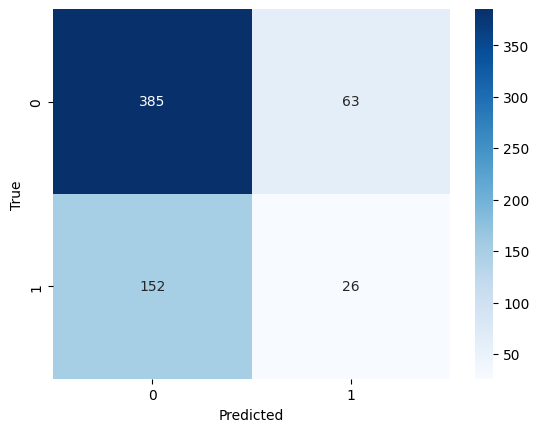

Accuracy: 0.6565495207667732
ROC AUC: 0.5027212078651685


In [86]:

model.eval()  # Set the model to evaluation mode

true_labels = []
pred_labels = []
outputs_list = []

# Loop through the test data
for inputs, labels in test_data_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    inputs = inputs[:, np.newaxis, :, :]
    inputs = inputs.float()


    # Forward pass
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)  # Get the predicted classes

    true_labels.extend(labels.cpu().numpy())
    pred_labels.extend(preds.cpu().numpy())
    outputs_list.extend(outputs.detach().cpu().numpy())

# Convert to numpy arrays for use with sklearn
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# Compute ROC AUC
roc_auc = roc_auc_score(label_binarize(true_labels, classes=[0,1]),
                        label_binarize(pred_labels, classes=[0,1]), 
                        average='macro')

# Compute accuracy
accuracy = accuracy_score(true_labels, pred_labels)

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
